In [1]:
import phippery
from phippery.utils import *

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA

In [2]:
pcs=3 # number of eigenassays to compute
np.random.seed(25)

# Okabe-Ito colors
oi_black         = '#000000'
oi_orange        = '#E69F00'
oi_skyblue       = '#56B4E9'
oi_bluishgreen   = '#009E73'
oi_yellow        = '#F0E442'
oi_blue          = '#0072B2'
oi_vermillion    = '#D55E00'
oi_reddishpurple = '#CC79A7'

# epitope region position boundaries
epitope_limits = {
    "FP"    : [ 805, 835],
    "SHH"   : [1135,1170]
}
epitope_colors = {
    "FP"    : oi_orange,
    "SHH"   : oi_skyblue
}

# output directory
outdir = "results"
if not os.path.exists(outdir): os.mkdir(outdir)

# input file
ds = phippery.load("LK_DMS_1rep_layered.phip")
ds

<xarray.Dataset>
Dimensions:                      (peptide_id: 24840, peptide_metadata: 6, sample_id: 78, sample_metadata: 31)
Coordinates:
  * peptide_id                   (peptide_id) int64 0 1 2 ... 24837 24838 24839
  * sample_id                    (sample_id) int64 1260 1262 1264 ... 1468 1420
  * sample_metadata              (sample_metadata) object 'Cohort' ... 'visit...
  * peptide_metadata             (peptide_metadata) object 'Oligo' ... 'is_wt'
Data variables:
    counts                       (peptide_id, sample_id) int64 0 0 ... 261 1270
    sample_table                 (sample_id, sample_metadata) object -1.0 ......
    peptide_table                (peptide_id, peptide_metadata) object 'aggaa...
    cpm                          (peptide_id, sample_id) float64 0.0 ... 1.35...
    size_factors                 (peptide_id, sample_id) float64 0.0 ... 1.04...
    enrichment                   (peptide_id, sample_id) float64 0.1664 ... 8...
    neg_binom_mlxp               (peptide_id, sample_id) float64 0.0 ... 3.37
    smooth_flank_1_enr_diff_sel  (peptide_id, sample_id) float64 -0.1379 ... ...
Attributes:
    collapsed_variable:  None

In [3]:
# restrict to wildtype peptides for LK individuals

wt_pids      = set(peptide_id_coordinate_subset(ds,where='is_wt',is_equal_to=True))
S1D614G_pids = set(peptide_id_coordinate_subset(ds,where='Protein',is_equal_to='S1D614G'))
pids_to_keep = list(wt_pids - S1D614G_pids)
pids_to_keep.sort()

lk_infant_sams = sample_id_coordinate_subset(ds,where='sample_group',is_equal_to='LK African Infant')
lk_mother_sams = sample_id_coordinate_subset(ds,where='sample_group',is_equal_to='LK African Mother')
sids = set.union(set(lk_infant_sams),set(lk_mother_sams))
wt_ds = ds.loc[dict(peptide_id=pids_to_keep, sample_id=list(sids))]
wt_ds

<xarray.Dataset>
Dimensions:                      (peptide_id: 1211, peptide_metadata: 6, sample_id: 45, sample_metadata: 31)
Coordinates:
  * peptide_id                   (peptide_id) int64 9 36 43 ... 24810 24827
  * sample_id                    (sample_id) int64 1413 1416 1420 ... 1492 1505
  * sample_metadata              (sample_metadata) object 'Cohort' ... 'visit...
  * peptide_metadata             (peptide_metadata) object 'Oligo' ... 'is_wt'
Data variables:
    counts                       (peptide_id, sample_id) int64 1 0 ... 161 276
    sample_table                 (sample_id, sample_metadata) object nan ... nan
    peptide_table                (peptide_id, peptide_metadata) object 'aggaa...
    cpm                          (peptide_id, sample_id) float64 1.32 ... 269.6
    size_factors                 (peptide_id, sample_id) float64 1.51 ... 659.5
    enrichment                   (peptide_id, sample_id) float64 0.1667 ... 1...
    neg_binom_mlxp               (peptide_id, sample_id) float64 0.3983 ... 1...
    smooth_flank_1_enr_diff_sel  (peptide_id, sample_id) float64 0.0 0.0 ... 0.0
Attributes:
    collapsed_variable:  None

In [4]:
# median filter smoothing to remove spike-enrichment peptides

def median_filter(enrichments,flank_size):
    output=[]
    nloc = len(enrichments)
        
    for loc in range(0, nloc):
        loc_min = max(0, loc-flank_size)
        loc_max = min(nloc, loc+flank_size+1)
        output.append(np.median(enrichments[loc_min:loc_max]))
    
    return output

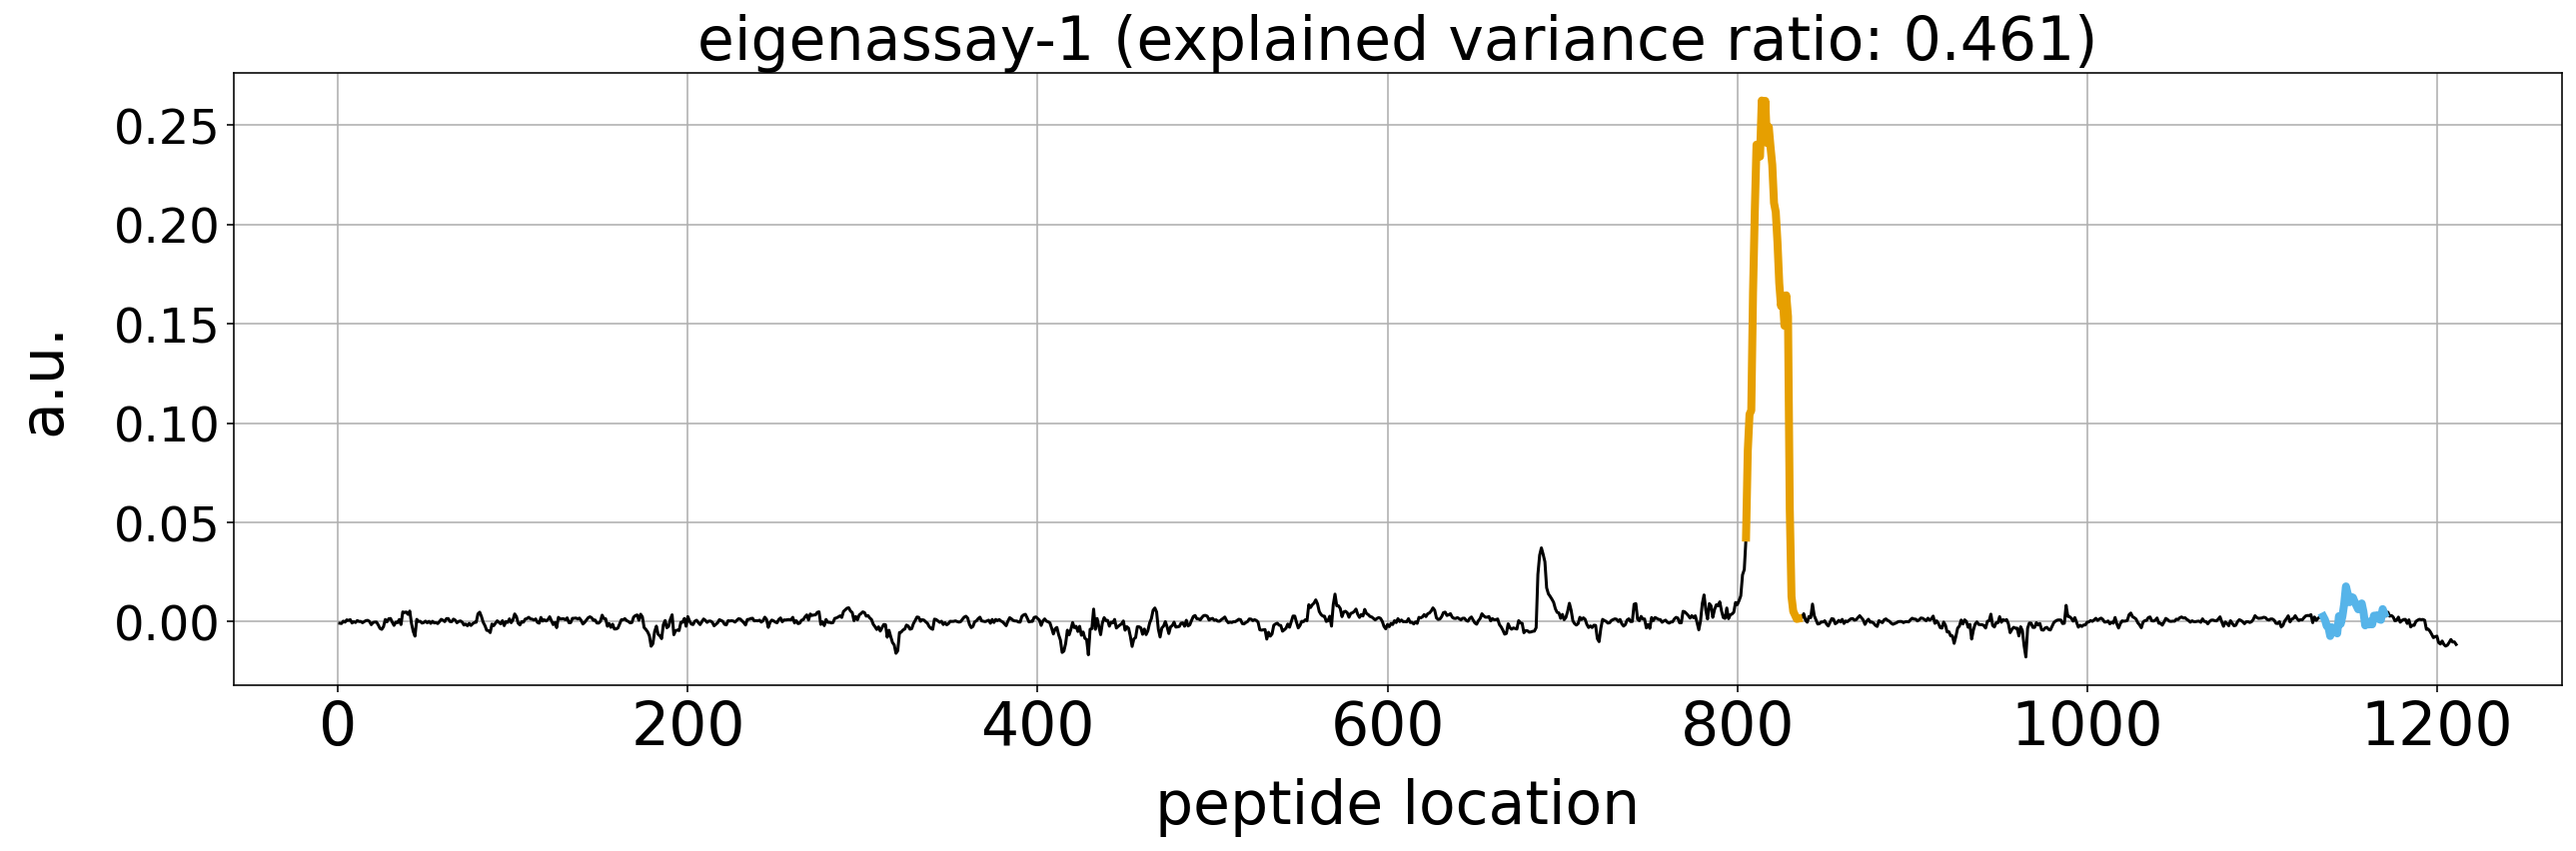

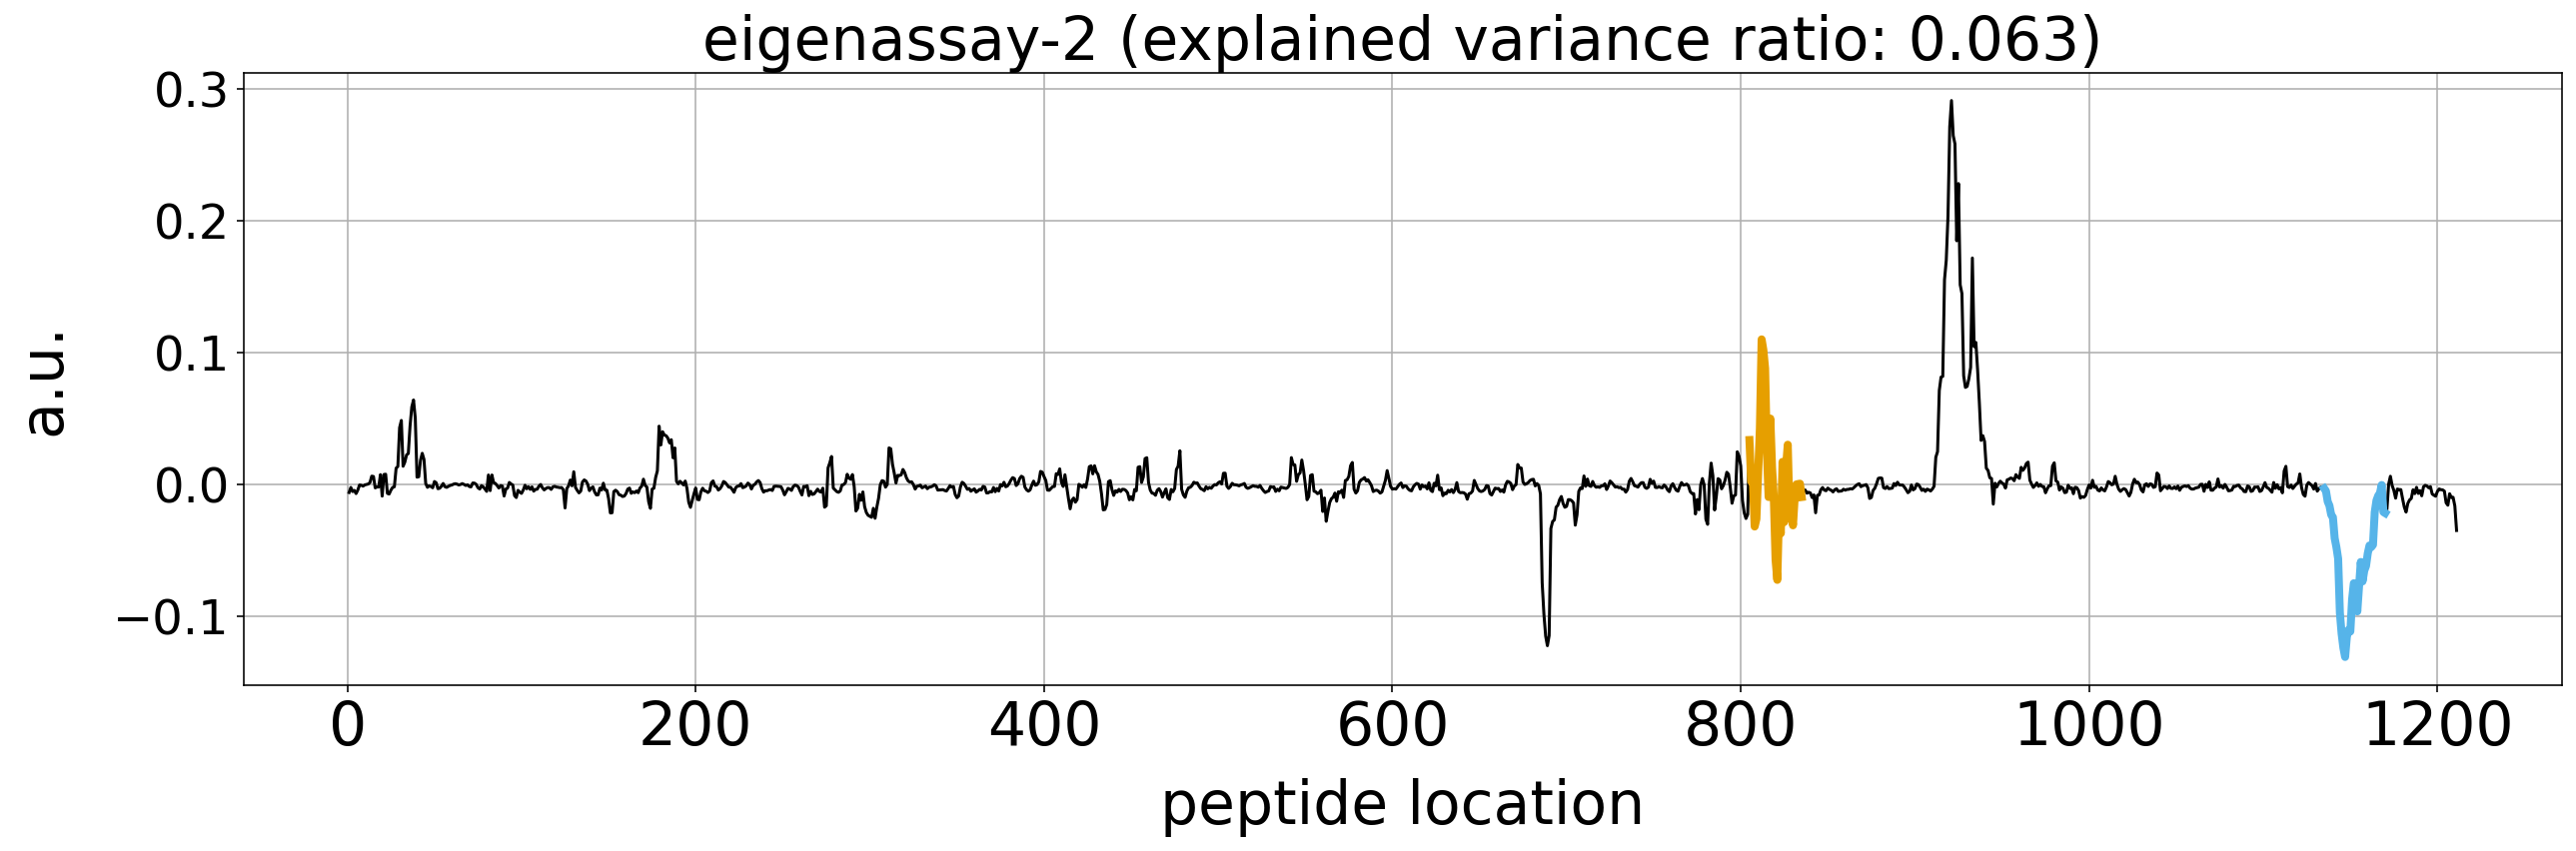

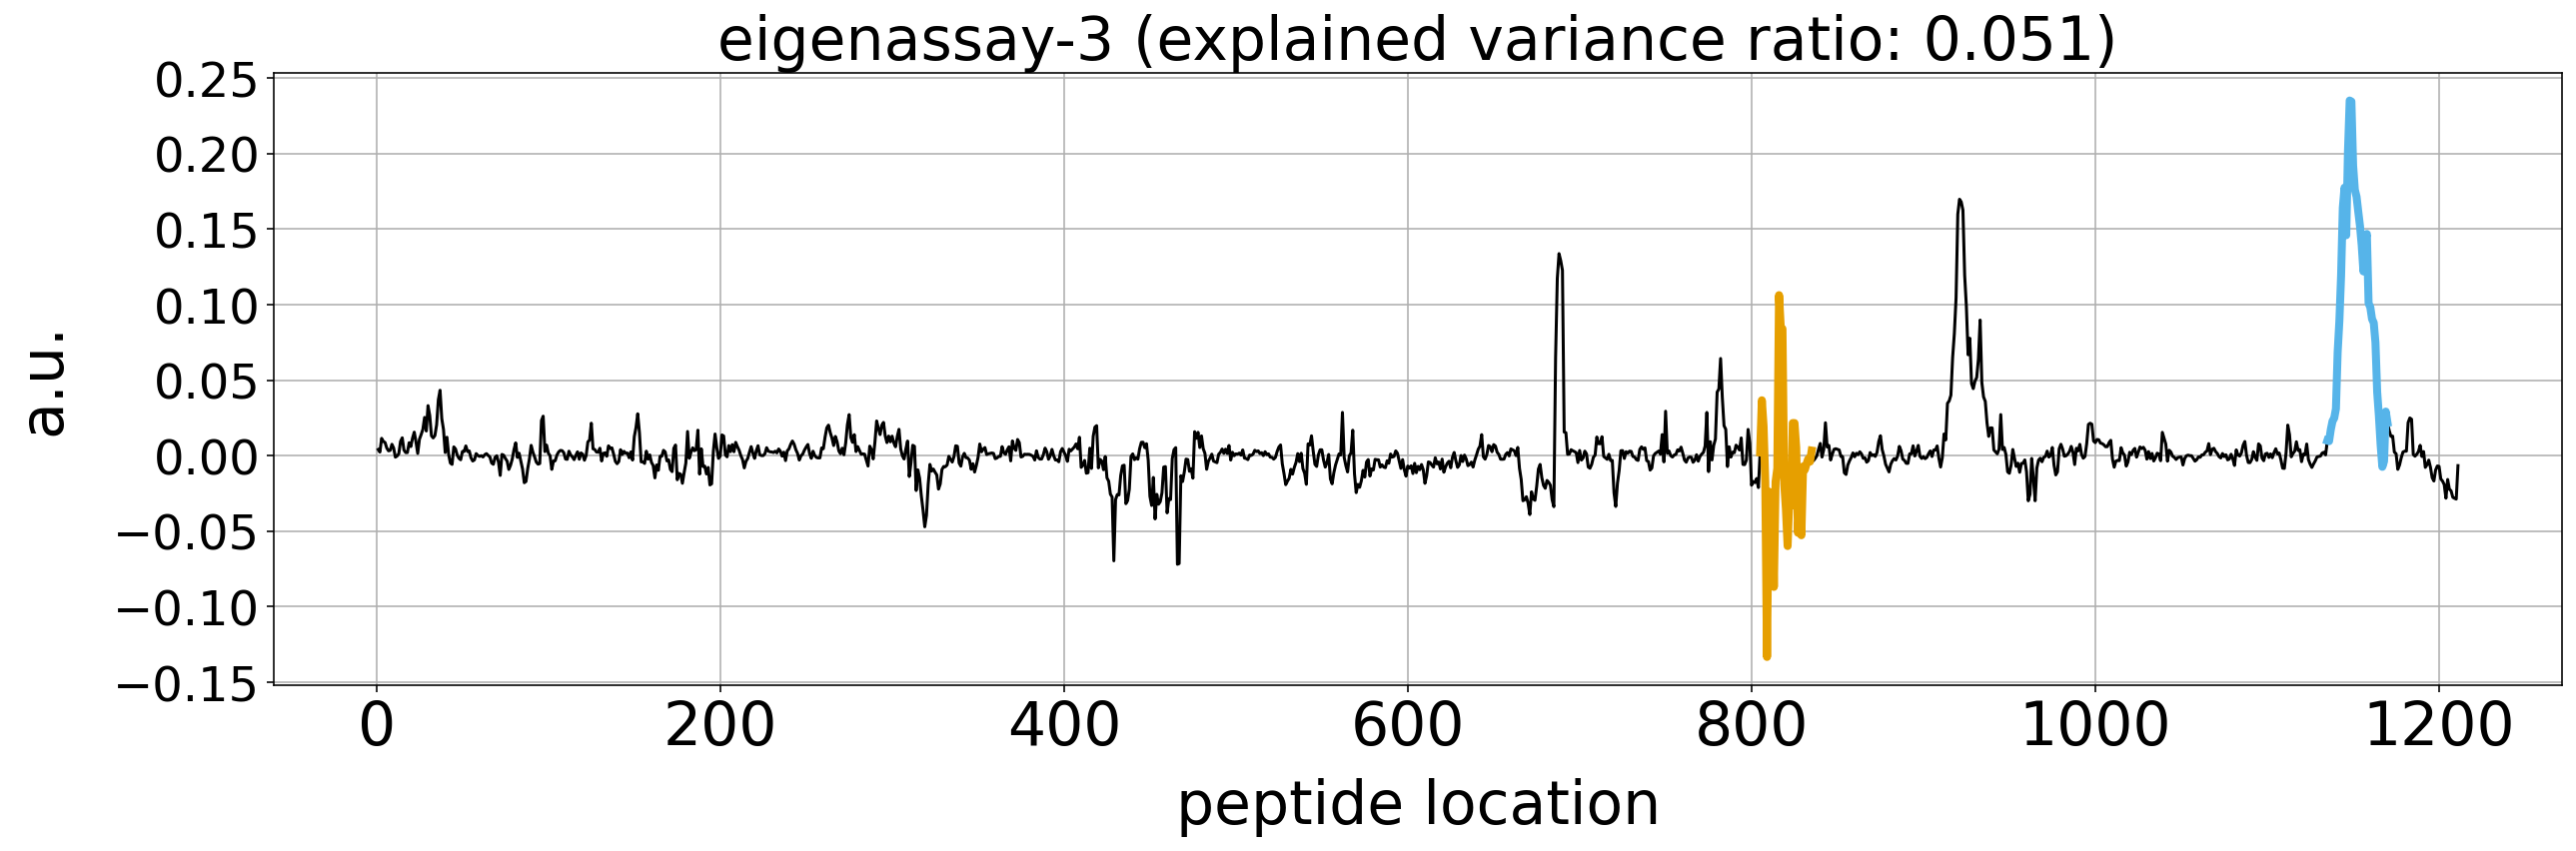

In [5]:
pca_p_table = wt_ds.peptide_table.loc[:,['Loc']].to_pandas().reset_index()
pca_s_table = wt_ds.sample_table.loc[:,['participant_ID']].to_pandas().reset_index(drop=True)

# enrichment matrix where each row is the enrichments for a sample 
enrichments_pca = wt_ds.enrichment.loc[dict(peptide_id=pca_p_table['peptide_id'].to_numpy())].values
enrichments_pca = enrichments_pca.transpose()

# median filter smoothing
for i in range(len(enrichments_pca)):
    enrichments_pca[i] = median_filter(enrichments_pca[i],1)

# perform PCA
pca = PCA(n_components=pcs)
projected = pca.fit_transform(enrichments_pca)

for pc in range(pcs):
    pca_s_table[f"PC-{pc+1}-proj"] = projected[:, pc]
    ys = projected[:, pc]
    scaley = 1.0/(ys.max() - ys.min())
    pca_s_table[f"PC-{pc+1}-scaled"] = ys * scaley

for pc in range(pcs):
    pca_p_table[f"loading-{pc+1}"] = pca.components_[pc, :]

loadings={}
for l in range(pcs):
    lname = f'loading-{l+1}'
    loadings[lname] = pca_p_table[lname]

peptide_locs = list(set(pca_p_table['Loc'].to_numpy()))

# plot eigenassays
for k in range(pcs):
    fig = plt.figure(figsize=[18,6])
    plt.plot(peptide_locs, loadings[f'loading-{k+1}'], color='k')
    for key in epitope_colors:
        plt.plot(peptide_locs[epitope_limits[key][0]-1:epitope_limits[key][1]],
                loadings[f'loading-{k+1}'][epitope_limits[key][0]-1:epitope_limits[key][1]],
                color=epitope_colors[key],
                linewidth=4)
    plt.grid()
    plt.title(f'eigenassay-{k+1} (explained variance ratio: {round(pca.explained_variance_ratio_[k],3)})',fontsize=30)
    plt.xticks(fontsize=30)
    plt.xlabel('peptide location', fontsize=30, labelpad=10)
    plt.yticks(fontsize=24)
    plt.ylabel('a.u.', fontsize=30, labelpad=20)
    plt.tight_layout()
    plt.savefig(f"{outdir}/eigenassay_{k+1}.pdf")
    outf = open(f"{outdir}/eigenassay_{k+1}.csv","w")
    outf.write('loc,val\n')
    for loc,val in zip(peptide_locs,loadings[f'loading-{k+1}']):
        outf.write(f'{loc},{val}\n')
    outf.close()
    plt.show()